# Customer Sentiment analysis

#### Introduction

The goal of the Customer Sentiment Analysis Project is to leverage natural language processing (NLP) techniques to systematically identify, extract, quantify, and study the emotional tone behind customer feedback, reviews, and social media mentions. This analysis will enable our organization to understand customer sentiments towards our products, services, and overall brand. By automating the sentiment analysis process, we aim to capture real-time insights into customer satisfaction, identify areas for improvement, and enhance customer experience. This project will not only help in monitoring brand reputation but also in tailoring marketing strategies, improving product features, and addressing customer concerns more effectively. Through this endeavor, we anticipate strengthening customer loyalty, increasing engagement, and fostering a positive brand perception in a competitive market landscape.

#### Dataset Description

The dataset, designed for financial sentiment analysis, is an amalgamation of the FiQA and Financial PhraseBank datasets. It encompasses a structured format of 5,842 rows and two distinct columns. These columns are detailed as follows:

    Sentence: This column contains various statements related to financial matters.
    
    Sentiment: This column categorizes the interpretation of each statement into one of three sentiment classes: negative, neutral, or positive.

This  dataset aims to provide a comprehensive foundation for analyzing and understanding the sentiment embedded within financial discourse.


#### Project Objectives

1. Understanding Customer Sentiments

    Automated Analysis: Deep learning models are capable of processing and understanding large volumes of text data much faster than humans can, providing quick insights into customer sentiment.
    Granularity: It can classify sentiments not just on a positive-negative spectrum, but can also identify neutral opinions, mixed feelings, or even the intensity of the sentiments.

2. Improving Customer Experience

    Identifying Pain Points: Sentiment analysis helps in pinpointing specific features or aspects of a product or service that customers are dissatisfied with.
    Service Enhancement: Insights gained can be used to make targeted improvements, thereby enhancing customer satisfaction and loyalty.

3. Supporting Decision Making

    Strategic Insights: The analysis provides strategic insights into market trends, customer preferences, and competitive positioning, aiding in informed decision-making.
    Product Development: Feedback analysis can guide product development by highlighting desired features or areas for improvement.

4. Enhancing Customer Engagement

    Personalized Marketing: Understanding customer sentiments helps in tailoring marketing and communication strategies to better align with customer emotions and preferences.
    Customer Support: Sentiment analysis can prioritize customer support by identifying and addressing negative sentiments swiftly, potentially turning dissatisfied customers into brand advocates.

5. Trend Analysis Over Time

    Tracking Sentiment Trends: It allows businesses to track changes in customer sentiment over time, helping to assess the impact of product launches, updates, or marketing campaigns.
    Market Research: Analyzing sentiment trends contributes to market research efforts by revealing how consumer attitudes change in response to internal and external factors.

In [1]:
# Import statements

import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import ngrams
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,f1_score,recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
import re
from wordcloud import WordCloud
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,SimpleRNN,Dropout,GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_tuner.tuners import RandomSearch
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import nltk
#nltk.download('omw-1.4')

In [2]:
#Reading the data
df = pd.read_csv('5k financial.csv')

#Displaying the first 5 rows of the dataframe
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Preprocessing

In [3]:
# Removing HTML Tags
df['Sentence'] = df['Sentence'].apply(lambda x: re.sub('<.*?>', '', x))

# Lowercasing
df['Sentence'] = df['Sentence'].str.lower()

# Removing Special Characters and Numbers
df['Sentence'] = df['Sentence'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# Handling Negations
# Function to handle negations
def handle_negations(sentence):
    # Define a negation pattern
    negation_pattern = r'\b(not|no|never|cannot|can\'t|don\'t|doesn\'t|didn\'t|won\'t|wouldn\'t|shouldn\'t|isn\'t|aren\'t)\b[\s]+([a-zA-Z]+)'
    # replacing the pattern with the merged negation
    modified_sentence = re.sub(negation_pattern, r'\1_\2', sentence)
    return modified_sentence

# Apply the function to the Sentences column
df['Sentence'] = df['Sentence'].apply(handle_negations)

# Tokenization
df['Tokens'] = df['Sentence'].apply(lambda x: nltk.word_tokenize(x))

# Removing Stop Words
stop_words = set(stopwords.words('english'))
common_words = ['the', 'and', 'is', 'it', 'in', 'of', 'this', 'that', 'are','company','eur','finnish','mn','finland']  # Add your common words here
stop_words.update(common_words)

df['Tokens'] = df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df.head(10)

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Tokens'] = df['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [4]:
# Displaying numbers of data points per each sentiment class
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

In [5]:
# Upsampling negative and positive values
df_negative = df[df['Sentiment'] == 'negative']
df_positive = df[df['Sentiment'] == 'positive']
df_neutral = df[df['Sentiment'] == 'neutral']

# Upsampling negative and positive values to match with neutral
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=42)
df_positive_upsampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=42)

# Concatenating the upsampled dataframes 
df_balanced = pd.concat([df_neutral, df_negative_upsampled, df_positive_upsampled])

# Shuffling the dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Train test split
X = df_balanced['Sentence']
y = df_balanced['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), padding='post')
padded_cols = pad_sequences(tokenizer.texts_to_sequences(df_balanced['Tokens']), padding='post')

df_balanced['padded'] = list(padded_cols)

In [6]:
df_balanced.head(10)

,Sentence,Sentiment,Tokens,padded
4803,at some point it will spread also to iran an...,neutral,"[point, spread, also, iran, iraq]","[805, 2036, 61, 2623, 5858, 0, 0, 0, 0, 0, 0, ..."
4679,rolls royce wins billion order from emira...,positive,"[roll, royce, win, billion, order, emirate, ai...","[4302, 2221, 1079, 117, 160, 4126, 607, 0, 0, ..."
3068,according to finnish petrol station chain st ...,negative,"[according, petrol, station, chain, st, managi...","[115, 1723, 1303, 442, 439, 681, 423, 1714, 27..."
2718,in finland sampo bank now part of the dans...,negative,"[sampo, bank, part, danske, bank, group, lay, ...","[552, 92, 185, 1653, 92, 44, 322, 342, 3530, 2..."
984,finnish insurance company fennia and kesko gro...,negative,"[insurance, fennia, kesko, group, ending, loya...","[403, 2977, 688, 44, 1181, 1803, 529, 536, 0, ..."
2474,inve see ya above,positive,"[inve, see, ya]","[8827, 314, 5707, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5445,after fixing our home base cutting costs a...,positive,"[fixing, home, base, cutting, cost, closing, n...","[1877, 593, 612, 692, 226, 1149, 203, 981, 138..."
3039,operating profit of the asian plants grew mark...,positive,"[operating, profit, asian, plant, grew, markedly]","[32, 17, 1069, 152, 316, 2615, 0, 0, 0, 0, 0, ..."
2320,this one was at one time targeted for june ...,neutral,"[one, one, time, targeted, june, guess, pushed...","[116, 116, 145, 5763, 239, 2654, 1958, 186, 15..."
15,fb gone green on day,positive,"[fb, gone, green, day]","[205, 1947, 772, 134, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
df_balanced['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    3130
negative    3130
Name: count, dtype: int64

In [8]:
df['Tokens'] = df['Tokens'].apply(tuple)
# Check for missing or null values
missing_values = df.isnull().sum()
print("Missing or Null Values:\n", missing_values)

# Check for duplicates
duplicate_rows = df.duplicated().sum()
print("Duplicate Rows:", duplicate_rows)


Missing or Null Values:
 Sentence     0
Sentiment    0
Tokens       0
dtype: int64
Duplicate Rows: 28


## EDA

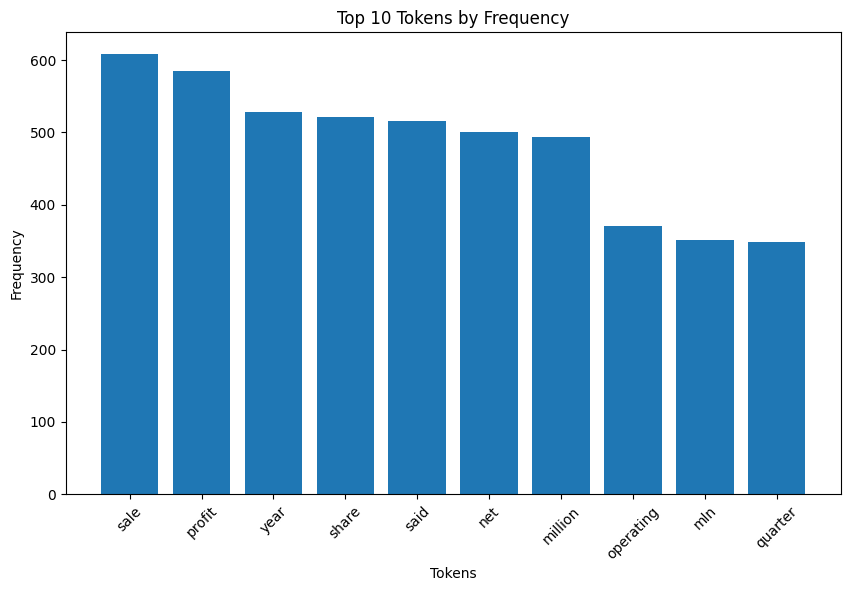

In [9]:
# Combine all tokens into a single list
all_tokens = [token for sublist in df["Tokens"] for token in sublist]

all_tokens_series = pd.Series(all_tokens)
# Count the frequency of each token
token_counts = all_tokens_series.value_counts()

# Select the top N tokens with the highest frequency
top_n = 10  
top_tokens = token_counts.head(top_n)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_tokens.index, top_tokens.values)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Tokens by Frequency')
plt.xticks(rotation=45)
plt.show()


In [10]:

def generate_word_cloud(sentiment):
    # Filter the dataframe based on the sentiment
    filtered_df = df[df['Sentiment'] == sentiment]

    # Combine all tokens into a single string
    tokens = ' '.join([token for sublist in filtered_df['Tokens'] for token in sublist])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokens)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

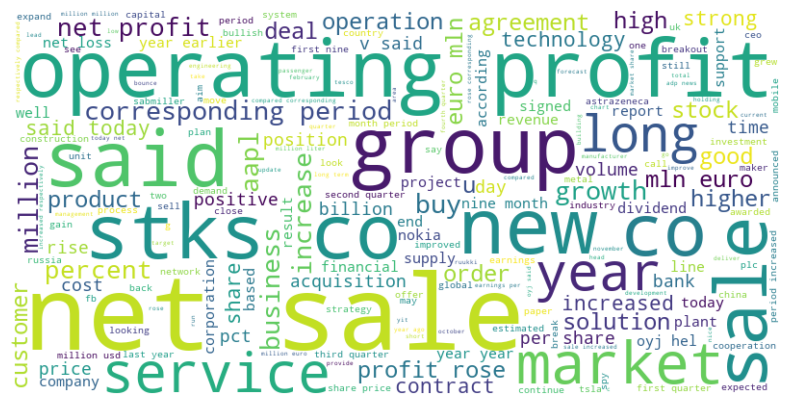

In [11]:
generate_word_cloud('positive')

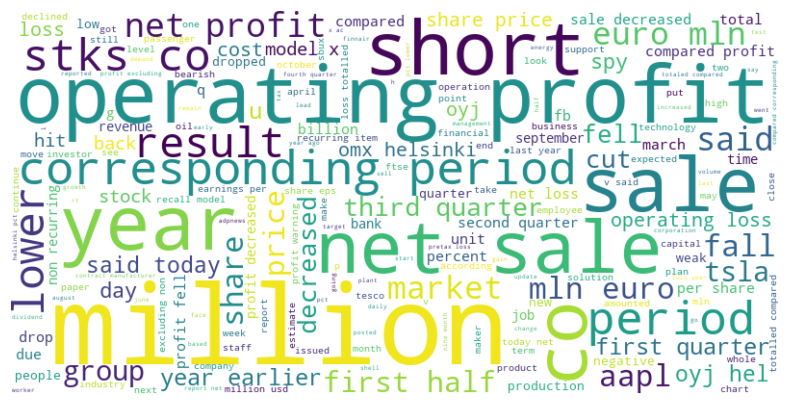

In [12]:
generate_word_cloud('negative')

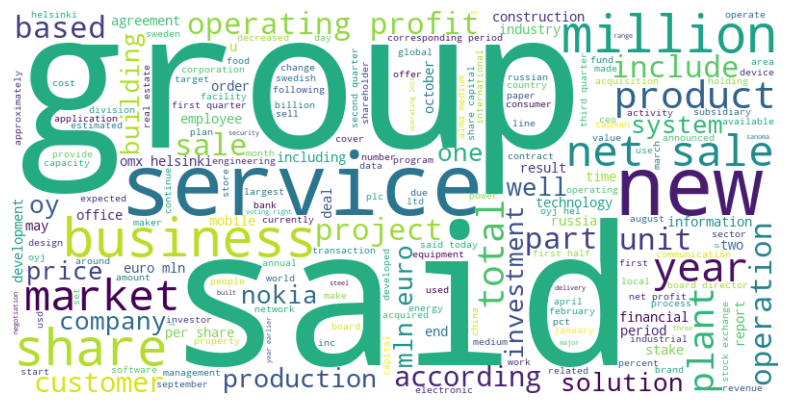

In [13]:
generate_word_cloud('neutral')

In [14]:
# N-Gram Analysis
# Define the number of most common n-grams you want to retrieve
n = 5

# Combine all tokens into a single list
all_tokens = [token for sublist in df['Tokens'] for token in sublist]

# Generate n-grams
ngram_counts = Counter(ngrams(all_tokens, n))

# Get the most common n-grams
most_common_ngrams = ngram_counts.most_common()

# Print the most common n-grams
for i, (ngram, count) in enumerate(most_common_ngrams):
    if i >= 10:
        break
    print(' : '.join(ngram), count)


operating : profit : excluding : non : recurring 20
profit : excluding : non : recurring : item 18
mln : euro : mln : mln : euro 17
euro : mln : mln : euro : mln 17
month : period : increased : respectively : compared 16
period : increased : respectively : compared : corresponding 12
earnings : per : share : eps : amounted 12
n : n : n : n : n 12
euro : mln : first : nine : month 11
increased : respectively : compared : corresponding : period 11


In [15]:
# Length Analysis
# Calculate the length of each feedback
df['Feedback_Length'] = df['Tokens'].apply(len)

# Group the data by sentiment and calculate the average feedback length
average_length_by_sentiment = df.groupby('Sentiment')['Feedback_Length'].mean()

# Print the average length by sentiment
print(average_length_by_sentiment)


Sentiment
negative    10.060465
neutral     11.117572
positive    10.912527
Name: Feedback_Length, dtype: float64


In [16]:
#Standardizing space
df['Tokens_String'] = df['Tokens'].apply(' '.join)
X = df['Tokens_String']
y = df['Sentiment']

# Convert the tokens to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Perform feature selection using SelectKBest and chi-square test
k = 10  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X_vectorized, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get chi-square scores for each feature
chi_scores = selector.scores_[selected_feature_indices]

# Get the names of the selected features
selected_features = [vectorizer.get_feature_names_out()[i] for i in selected_feature_indices]

# Print the selected features and their chi-square scores
print("Selected Features and their Chi-Square Scores:")
for feature, score in zip(selected_features[:10], chi_scores[:10]):
    print(f"{feature}: {score}")


Selected Features and their Chi-Square Scores:
co: 40.62557758028903
decreased: 45.75306722594083
fell: 32.488061131929584
http: 47.91167622535302
increased: 38.41282665885683
long: 27.719074097142375
rose: 62.50993397341141
short: 35.072419411489996
stks: 28.582329867496725
tsla: 28.98791976572505


## Feature Engineering

In [17]:
#Standardizing space
df_balanced['Tokens_String'] = df_balanced['Tokens'].apply(' '.join)

# Encode the target variable
le = LabelEncoder()
df_balanced['Sentiment_Encoded'] = le.fit_transform(df_balanced['Sentiment'])
y_encoded = le.fit_transform(y)

# Split the data into features and target
X = df_balanced['Tokens_String']
y = df_balanced['Sentiment_Encoded']
y_encoded = le.fit_transform(y)

# Convert the tokens to numerical features using Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

X_encoded = tokenizer.texts_to_sequences(X)
# Pad sequences to have the same length
X_padded = pad_sequences(X_encoded,maxlen=41)

## Baseline Modelling

In [18]:
#NAIVE BAYES

# Join tokens into a single string for each document in the dataframe
df_balanced['Tokens_String'] = df_balanced['Tokens'].apply(' '.join)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Transform the text data into TF-IDF feature vectors
X_vectorized = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# Initialize the Multinomial Naive Bayes model
Naive_model = MultinomialNB()
# Train the model on the training data
Naive_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = Naive_model.predict(X_test)

# Calculate and print the accuracy of the model on the test set
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# Generate and print a classification report to see the performance on a class-by-class basis
print(classification_report(y_test, y_pred, target_names=['negative','neutral','positive']))


Accuracy: 0.7832800851970181
              precision    recall  f1-score   support

    negative       0.73      0.90      0.80       603
     neutral       0.79      0.68      0.73       665
    positive       0.85      0.78      0.81       610

    accuracy                           0.78      1878
   macro avg       0.79      0.79      0.78      1878
weighted avg       0.79      0.78      0.78      1878



In [19]:
#LOGISTIC REGRSSION

logregmodel = LogisticRegression(max_iter=1000)  # Increasing max_iter for convergence with large datasets
logregmodel.fit(X_train, y_train)


y_pred = logregmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8168264110756124
Precision: 0.8183825846353527
Recall: 0.8168264110756124
F1 Score: 0.8158542981998314


## Model Selection

### Preprocessing

In [20]:
# Creating a confusion matrix function
def confusion_matrix_plot(model,X_test):

    #Model predictions on the test set
    y_pred = model.predict(X_test)

    #Model predictions class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Define custom tick labels
    tick_labels = ['Negative', 'Neutral', 'Positive']

    # Plotting the heatmap
    sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', xticklabels=tick_labels, yticklabels=tick_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [21]:
# Creating a ROC curve function
def aucroc(model, X_test, y_test, num_classes):
    # model predictions on the test set
    y_pred = model.predict(X_test)  

    # Binarize the output labels for multiclass
    y_test_bin = label_binarize(y_test, classes=[*range(num_classes)])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


In [22]:
#RNN

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=1000)


Epoch 1/10
8/8 [==============================] - 2s 138ms/step - loss: 1.0809 - accuracy: 0.4081 - val_loss: 1.0333 - val_accuracy: 0.5655
Epoch 2/10
8/8 [==============================] - 1s 107ms/step - loss: 0.9459 - accuracy: 0.7266 - val_loss: 0.9316 - val_accuracy: 0.6794
Epoch 3/10
8/8 [==============================] - 1s 99ms/step - loss: 0.7566 - accuracy: 0.8384 - val_loss: 0.7866 - val_accuracy: 0.7220
Epoch 4/10
8/8 [==============================] - 1s 101ms/step - loss: 0.5474 - accuracy: 0.8751 - val_loss: 0.6753 - val_accuracy: 0.7396
Epoch 5/10
8/8 [==============================] - 1s 101ms/step - loss: 0.3987 - accuracy: 0.8958 - val_loss: 0.6312 - val_accuracy: 0.7678
Epoch 6/10
8/8 [==============================] - 1s 100ms/step - loss: 0.3156 - accuracy: 0.9096 - val_loss: 0.6127 - val_accuracy: 0.7396
Epoch 7/10
8/8 [==============================] - 1s 100ms/step - loss: 0.2889 - accuracy: 0.8971 - val_loss: 0.5945 - val_accuracy: 0.7891
Epoch 8/10
8/8 [=====

In [23]:
# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

59/59 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.8136
Test Loss: 0.5556106567382812
Test Accuracy: 0.813631534576416


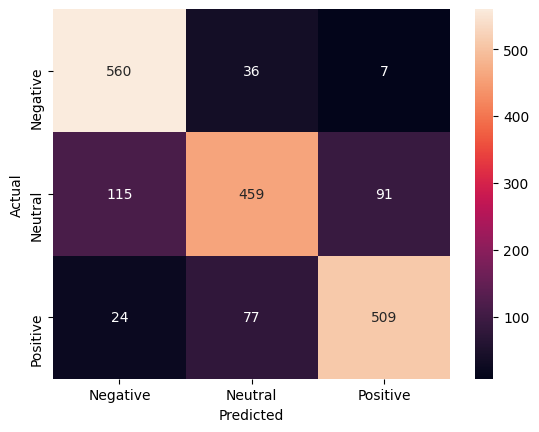

In [24]:
confusion_matrix_plot(rnn_model,X_test)

    Key Insights:

    Overall Performance:
The model performs well, showing a high number of correct predictions in all three sentiment categories.

It effectively distinguishes between Negative and Positive sentiments, with fewer errors in these categories.

    Class-wise Accuracy:
    
Negative Sentiment: High accuracy with minimal confusion.

Neutral Sentiment: Moderate accuracy with some misclassification, particularly with neighboring classes.

Positive Sentiment: Strong performance, correctly identifying most positive sentiments.

    Misclassifications:
The model tends to confuse Neutral sentiments with Negative and Positive ones, which is common due to the ambiguous nature of neutral sentiments.

    Recommendations:

    Improve Neutral Sentiment Classification:

    Conduct Error Analysis:

Analyze misclassified instances to understand specific characteristics and improve the model accordingly.

    Enhance Validation:
    
Use cross-validation and external validation datasets to ensure the model's robustness and generalizability.

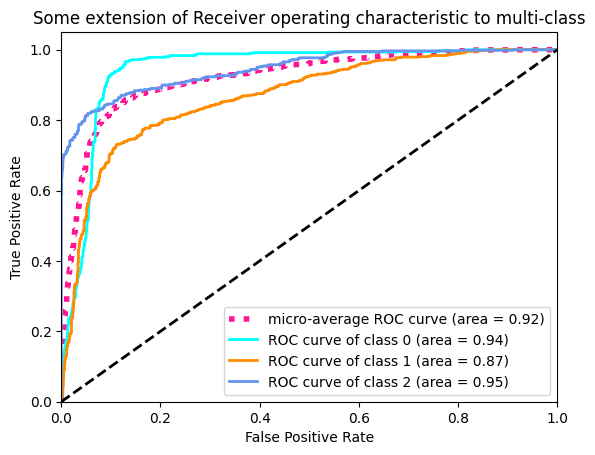

In [25]:
aucroc(rnn_model, X_test, y_test, 3)

In [26]:
#GRU
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Define the GRU model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]))
gru_model.add(GRU(64))
gru_model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=1000)


Epoch 1/10
8/8 [==============================] - 4s 294ms/step - loss: 1.0908 - accuracy: 0.4336 - val_loss: 1.0781 - val_accuracy: 0.5586
Epoch 2/10
8/8 [==============================] - 2s 196ms/step - loss: 1.0514 - accuracy: 0.6924 - val_loss: 1.0325 - val_accuracy: 0.6475
Epoch 3/10
8/8 [==============================] - 2s 195ms/step - loss: 0.9716 - accuracy: 0.7480 - val_loss: 0.9437 - val_accuracy: 0.6805
Epoch 4/10
8/8 [==============================] - 2s 197ms/step - loss: 0.8243 - accuracy: 0.7682 - val_loss: 0.8188 - val_accuracy: 0.6986
Epoch 5/10
8/8 [==============================] - 2s 190ms/step - loss: 0.6463 - accuracy: 0.7902 - val_loss: 0.7123 - val_accuracy: 0.7412
Epoch 6/10
8/8 [==============================] - 2s 217ms/step - loss: 0.4797 - accuracy: 0.8440 - val_loss: 0.6017 - val_accuracy: 0.7764
Epoch 7/10
8/8 [==============================] - 2s 210ms/step - loss: 0.3663 - accuracy: 0.8725 - val_loss: 0.5536 - val_accuracy: 0.7897
Epoch 8/10
8/8 [====

In [27]:
# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

59/59 [==============================] - 0s 6ms/step - loss: 0.5268 - accuracy: 0.8222
Test Loss: 0.5268489718437195
Test Accuracy: 0.822151243686676


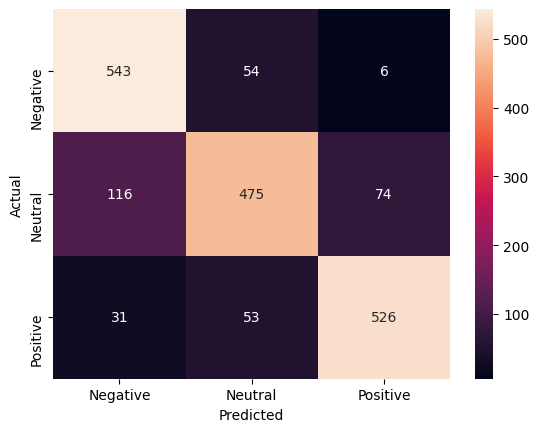

In [28]:
confusion_matrix_plot(gru_model,X_test)

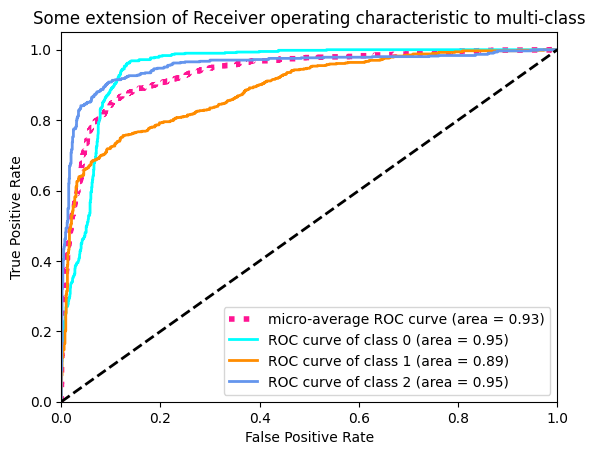

In [29]:
aucroc(gru_model, X_test, y_test, 3)

In [30]:
#LSTM
# Define the number of classes
num_classes = len(set(y))

# Define the RNN model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_padded, y, epochs=10, batch_size=32)

Epoch 1/10
294/294 [==============================] - 11s 31ms/step - loss: 0.7320 - accuracy: 0.6740
Epoch 2/10
294/294 [==============================] - 9s 30ms/step - loss: 0.3304 - accuracy: 0.8781
Epoch 3/10
294/294 [==============================] - 9s 31ms/step - loss: 0.2367 - accuracy: 0.9109
Epoch 4/10
294/294 [==============================] - 10s 33ms/step - loss: 0.2048 - accuracy: 0.9227
Epoch 5/10
294/294 [==============================] - 10s 34ms/step - loss: 0.1822 - accuracy: 0.9288
Epoch 6/10
294/294 [==============================] - 10s 35ms/step - loss: 0.1797 - accuracy: 0.9277
Epoch 7/10
294/294 [==============================] - 13s 45ms/step - loss: 0.1709 - accuracy: 0.9321
Epoch 8/10
294/294 [==============================] - 13s 43ms/step - loss: 0.1655 - accuracy: 0.9340
Epoch 9/10
294/294 [==============================] - 12s 42ms/step - loss: 0.1592 - accuracy: 0.9347
Epoch 10/10
294/294 [==============================] - 11s 39ms/step - loss: 0.1564 

In [31]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

59/59 [==============================] - 1s 8ms/step - loss: 0.1463 - accuracy: 0.9414
Test Loss: 0.14631405472755432
Test Accuracy: 0.9414270520210266


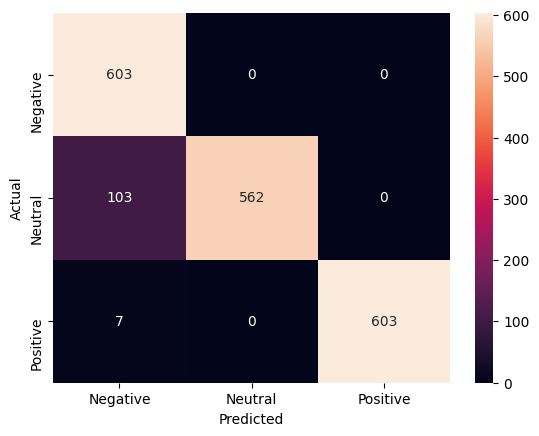

In [32]:
confusion_matrix_plot(lstm_model,X_test)

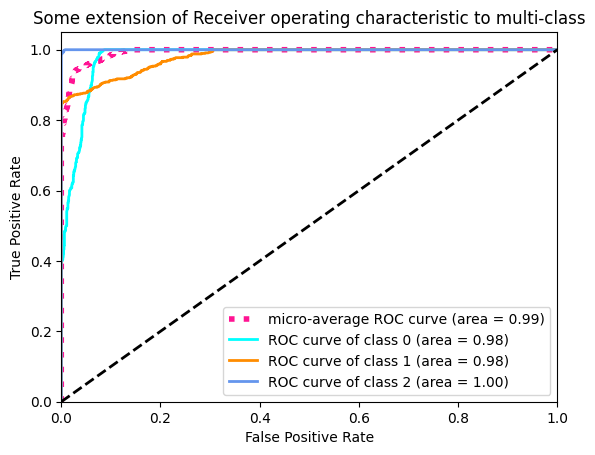

In [33]:
aucroc(lstm_model, X_test, y_test, 3)

In [34]:
def lstm_tuned_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]))
    model.add(LSTM(hp.Int('lstm_units', min_value=50, max_value=300, step=50)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax')) 

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = RandomSearch(
    RNN,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3, 
    directory='my_dir',
    project_name='rnn_tuning')

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_lstm = tuner.hypermodel.build(best_hp)

# Train the best model (optional)
best_model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Predict on new data
predictions = best_model_lstm.predict(X_test)

NameError: name 'RNN' is not defined

In [ ]:
# Evaluate the model
loss, accuracy = best_model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

59/59 [==============================] - 0s 7ms/step - loss: 0.7085 - accuracy: 0.8552
Test Loss: 0.7085222005844116
Test Accuracy: 0.8551650643348694


 1/59 [..............................] - ETA: 2s

59/59 [==============================] - 0s 7ms/step


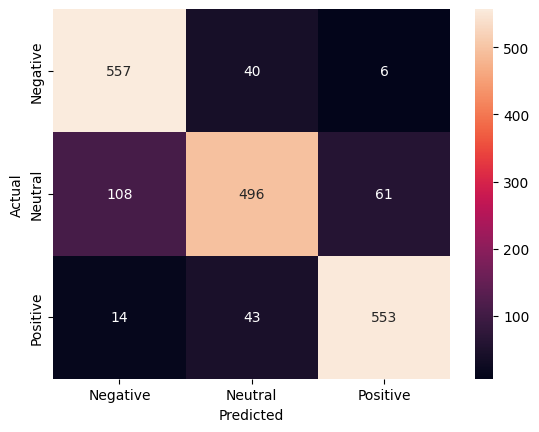

In [ ]:
confusion_matrix_plot(best_model_lstm,X_test)

59/59 [==============================] - 0s 7ms/step


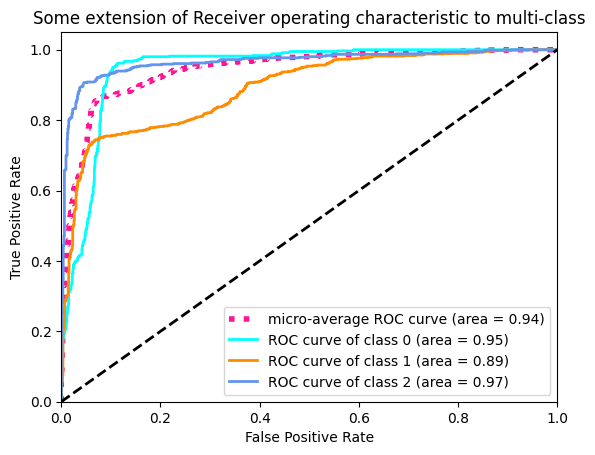

In [ ]:
aucroc(best_model_lstm, X_test, y_test, 3)

In [ ]:
# create a dictionary to store the error metrics for each model
models = {'RNN': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'LSTM': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'GRU': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'LSTM_TUNED': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}}

# calculate the error metrics for each model
y_preds = {'RNN': rnn_model.predict(X_test),
           'LSTM': gru_model.predict(X_test),
           'GRU': lstm_model.predict(X_test),
           'LSTM_TUNED': best_model_lstm.predict(X_test)}

# for model_name, y_pred in y_preds.items():
#     models[model_name]['Accuracy'] = accuracy_score(y_test, y_pred)
#     models[model_name]['Precision'] = precision_score(y_test, y_pred, average='weighted')
#     models[model_name]['Recall'] = recall_score(y_test, y_pred, average='weighted')
#     models[model_name]['F1'] = f1_score(y_test, y_pred, average='weighted')

for model_name, y_pred in y_preds.items():
    # Convert probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=-1)
    
    models[model_name]['Accuracy'] = accuracy_score(y_test, y_pred_labels)
    models[model_name]['Precision'] = precision_score(y_test, y_pred_labels, average='weighted')
    models[model_name]['Recall'] = recall_score(y_test, y_pred_labels, average='weighted')
    models[model_name]['F1'] = f1_score(y_test, y_pred_labels, average='weighted')
# create a dataframe from the dictionary
df_models = pd.DataFrame(models).T
df_models

 1/59 [..............................] - ETA: 1s

59/59 [==============================] - 0s 6ms/step


,Accuracy,Precision,Recall,F1
RNN,0.815761,0.815127,0.815761,0.813725
LSTM,0.830138,0.830369,0.830138,0.828075
GRU,0.940362,0.948368,0.940362,0.940514
LSTM_TUNED,0.855165,0.856447,0.855165,0.853447


In [ ]:
# Calculate the sum of all metrics for each model
df_models['Sum'] = df_models.sum(axis=1)

# Find the model with the highest sum of metrics
best_model_name = df_models['Sum'].idxmax()

print(f"The best model is: {best_model_name}")

The best model is: GRU


Although the GRU model is currently the best performing model, it is exhibiting signs of overfitting. To address this issue and increase its variance, the GRU model will be revisited and appropriate actions will be taken, such as Regularization, Early Stopping, Reducing model complexity and Gradient clipping.